In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

### Turn string type to int/float


In [3]:
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df['Month'] = df['Month'].map(month_mapping)

### Encoding the visitor_type

In [4]:
df_encoded = pd.get_dummies(df, columns=['VisitorType', 'Browser', 'Region', 'OperatingSystems','TrafficType'])
df_encoded

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,...,False,False,False,False,False,False,False,False,False,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,...,False,False,True,False,False,False,False,False,False,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,...,True,False,False,False,False,False,False,False,False,False


# Modeling

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

df_train, df_test = train_test_split(df_encoded, test_size = 0.1, random_state=42)
X_test = df_test.drop('Revenue', axis = 1)
y_test = df_test['Revenue'].copy()
df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state=42)
X_train = df_train.drop('Revenue', axis = 1)
y_train = df_train['Revenue'].copy()
X_val = df_test.drop('Revenue', axis = 1)
y_val = df_test['Revenue'].copy()

In [30]:
def evaluate(y_val, y_pred, y_probs):
    # Evaluation
    conf_matrix = confusion_matrix(y_val, y_pred)
    print(classification_report(y_val, y_pred, digits=3))

    # confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def grid_search(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best parameters:", best_params)

    best_score = grid_search.best_score_
    print("Best score:", best_score)

    return grid_search.best_estimator_

### SVM

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=  29.9s
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=  30.9s
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=  28.9s
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=  29.0s
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=  28.7s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=  47.7s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=  47.0s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=  47.3s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time= 1.9min
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=  47.6s
[CV] END .........classifier__C=0.1, classifier__kernel=poly; total time=  43.5s
[CV] END .........classifier__C=0.1, classifier_

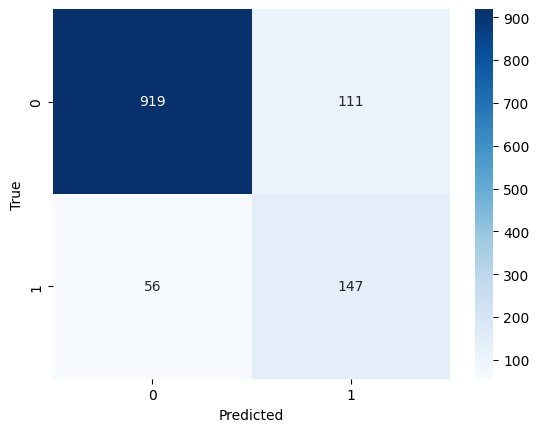

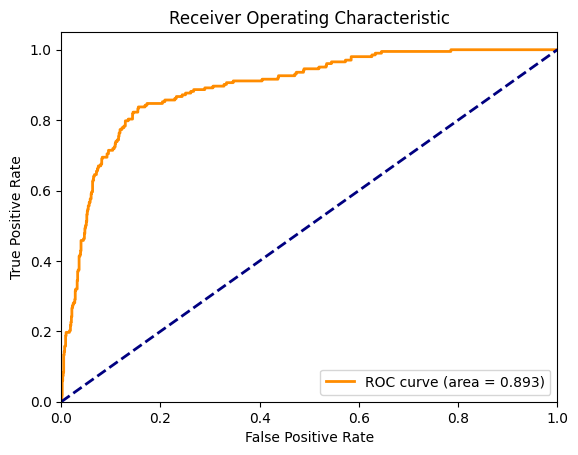

In [34]:
from sklearn.svm import SVC

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', SVC(probability=True))])

# Define the parameter grid
param_grid = {
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classifier__C': [0.1, 1, 10]
}

best_estimator = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator.predict(X_val)
y_probs = best_estimator.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)

## Logistic Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .................................classifier__C=0.01; total time=   0.1s
[CV] END .................................classifier__C=0.01; total time=   0.2s
[CV] END .................................classifier__C=0.01; total time=   0.1s
[CV] END .................................classifier__C=0.01; total time=   0.2s
[CV] END .................................classifier__C=0.01; total time=   0.2s
[CV] END ..................................classifier__C=0.1; total time=   0.3s
[CV] END ..................................classifier__C=0.1; total time=   0.2s
[CV] END ..................................classifier__C=0.1; total time=   0.2s
[CV] END ..................................classifier__C=0.1; total time=   0.3s
[CV] END ..................................classifier__C=0.1; total time=   0.4s
[CV] END ....................................classifier__C=1; total time=   0.2s
[CV] END ....................................clas

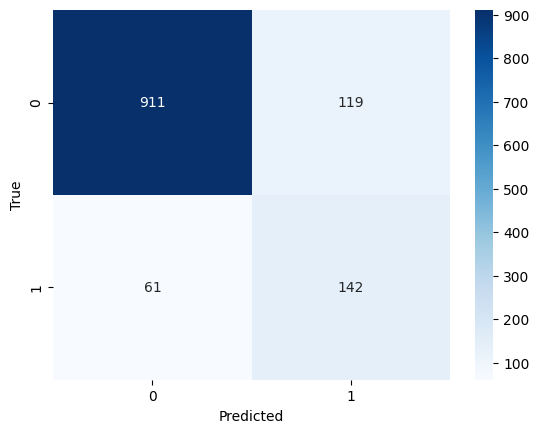

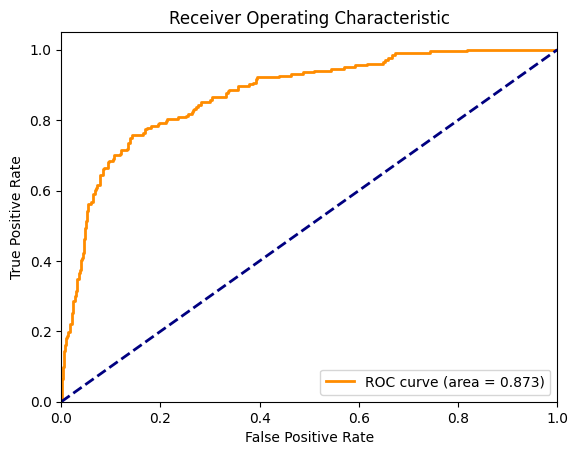

In [35]:
from sklearn.linear_model import LogisticRegression

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', LogisticRegression())])
param_grid = {
    'classifier__C': [ 0.01, 0.1, 1, 10]
}

best_estimator = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator.predict(X_val)
y_probs = best_estimator.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)

## Decision Tree

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=50; total time=   0.1s
[CV]

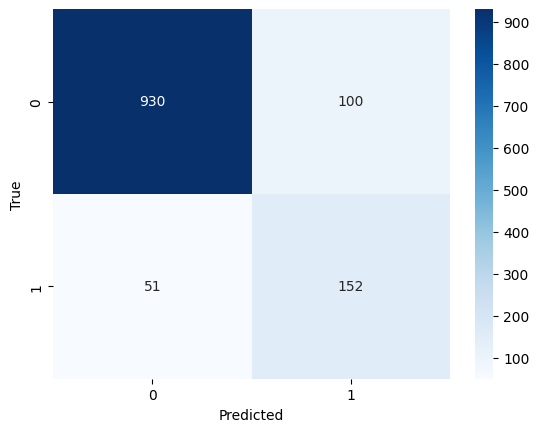

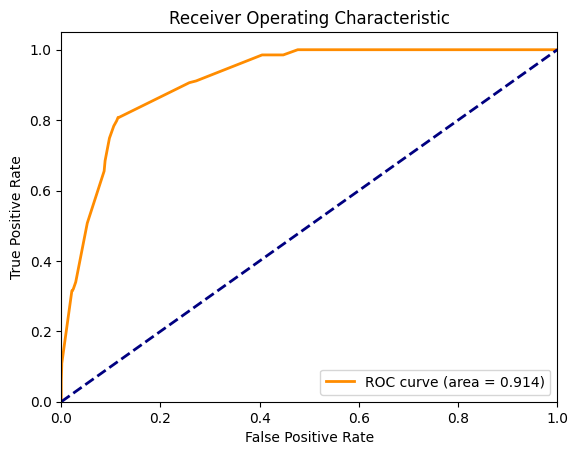

In [36]:
from sklearn.tree import DecisionTreeClassifier

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=42))])
param_grid = {
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 50]
}

best_estimator = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator.predict(X_val)
y_probs = best_estimator.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)

## Random Forest

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   1.9s
[CV] END classifie

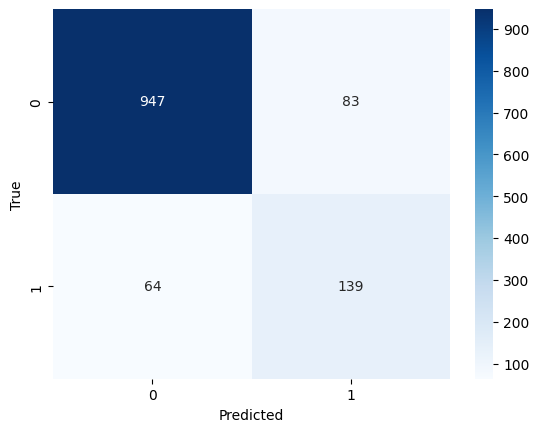

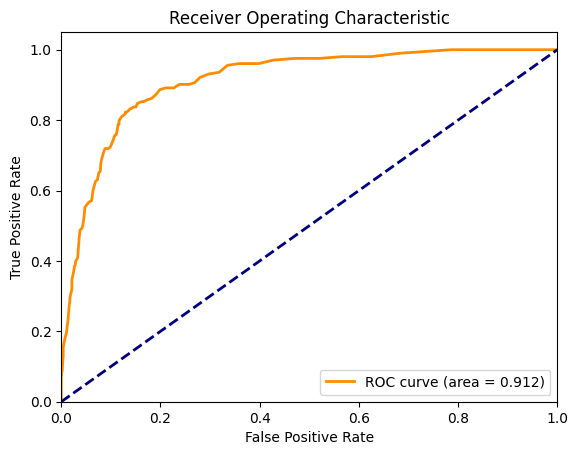

In [37]:
from sklearn.ensemble import RandomForestClassifier

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', RandomForestClassifier(criterion='entropy', random_state=42))])
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 50]
}

best_estimator = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator.predict(X_val)
y_probs = best_estimator.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)

## Gradient Boost Decision Tree

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.8s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200; total time=   1.0s
[CV] END classifie

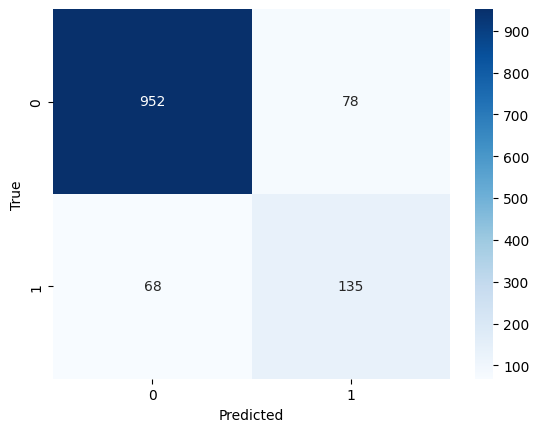

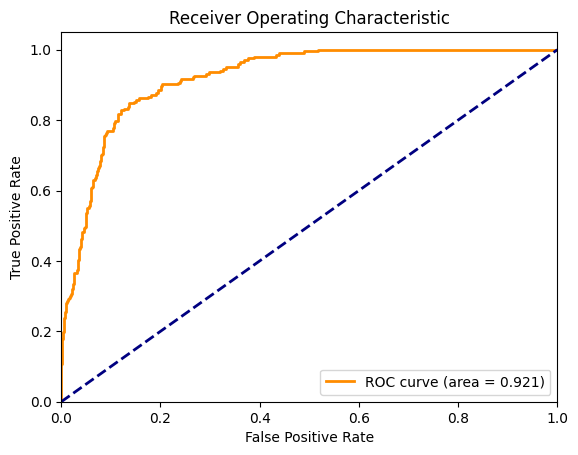

In [33]:
from xgboost import XGBClassifier

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', XGBClassifier(random_state=42))])
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, None],
}

best_estimator = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator.predict(X_val)
y_probs = best_estimator.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)